In [164]:
#Let's get rid of some imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#Define the model 
import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense

# SOME DATA PREP

In [165]:
def loadData():
    return pd.read_excel('data/boston.xls')  


In [166]:
df = loadData()

In [167]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PT,B,LSTAT,MV
0,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98,24.000000
1,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14,21.600000
2,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03,34.700001
3,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94,33.400002
4,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33,36.200001


In [168]:
X = list(df.columns)
X.remove("MV")
y = ["MV"]

In [169]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test[X], y_test[y], random_state=42)

In [170]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)

# KERAS

In [217]:
import tensorflow.keras.backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

#build our model
model = Sequential()

model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=[soft_acc, metrics.MeanSquaredError()])

In [218]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
12/12 [==============================] - 0s 3ms/step - loss: 616.9249 - soft_acc: 0.0000e+00 - mean_squared_error: 616.9249
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 560.5459 - soft_acc: 0.0000e+00 - mean_squared_error: 560.5459
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 482.8576 - soft_acc: 0.0035 - mean_squared_error: 482.8576
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 272.9755 - soft_acc: 0.0074 - mean_squared_error: 272.9755
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 159.6907 - soft_acc: 0.0318 - mean_squared_error: 159.6907
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 124.9038 - soft_acc: 0.0659 - mean_squared_error: 124.9038
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 112.7720 - soft_acc: 0.0496 - mean_squared_error: 112.7720
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - l

<BarContainer object of 95 artists>

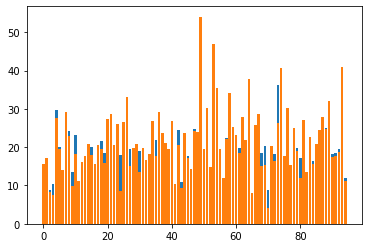

In [251]:
X_test = min_max_scaler.fit_transform(X_test)
ypred = model.predict(X_test)

plt.bar(range(len(ypred)),y_test['MV'])
plt.bar(range(len(ypred)),ypred.flatten())
# plt.bar(y_test,color="red")

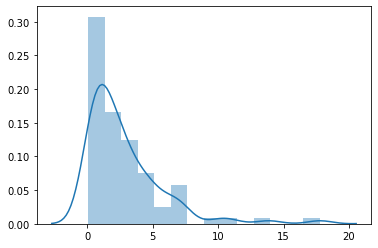

In [222]:
error = abs(y_test - ypred)
sns.distplot(error)

# PYTORCH